# BEFORE YOU START

* Make sure you have the latest julia, julip, ace, installed
* Change the JULIA_UTILS_PATH in ace_interface.py to point to your castle folder
* Copy the delta_silicon.xyz data to "../data/Si_2018/delta_silicon.xyz"

In [1]:
from ase.io import read
import numpy as np
from matplotlib import pyplot as plt
import joblib, pickle, sys

sys.path.insert(0,"/home/claudio/postdoc/Castle/")
from castle import ASEMLCalculator, AceGlobalRepresentation, AceLocalRepresentation, LPEnsamble, LinearPotential
from castle import get_forces_and_energies, get_virials, get_nat, dump, load, print_score, utils

def split_dataset(N, training_percentage, seed=20):
    np.random.seed(seed)
    ids = list(range(N))
    np.random.shuffle(ids)
    return ids[:int(training_percentage*N)], ids[int(training_percentage*N):]

%load_ext autoreload
%autoreload 2

# Load structures

In [2]:
# Load xyz data
input_file =  "../data/Si_2018/delta_silicon.xyz"
input_file =  "../data/Si_2018/delta_silicon.xyz"

frames_ = read(input_file, index = ':')
    
# Wrap positions so rascal does not complain
for ff in frames_:
    ff.wrap(eps=1e-11)
energy_name = 'dft_energy'
force_name = 'dft_force'
virial_name = 'dft_virial'

In [3]:
tags = set()
for ff in frames_:
    tags.add(ff.info['config_type'])
print(tags)

{'bt', 'divacancy', '111adatom', 'hcp', 'sp2', 'bcc', 'crack_111_1-10', 'sh', 'surface_111_pandey', 'decohesion', 'st12', 'surface_001', 'bc8', 'surface_111', 'amorph', 'surface_110', 'interstitial', 'vacancy', 'liq', 'dia', 'screw_disloc', 'crack_110_1-10', 'fcc', 'sp', 'hex_diamond', 'isolated_atom', 'surface_111_3x3_das'}


In [4]:
frames = []
for ff in frames_:
    # if ff.info['config_type'] in ['amorph', 'bt', 'dia', 'liq', 'fcc', 'bcc', 'hcp', 'hex_diamond']:
    try:
        len(ff.info['dft_virial'])
        frames.append(ff)
    except KeyError:
        pass

# Build a model

Compute representation

In [5]:
# Create training and validation set
tr_ind, val_ind = split_dataset(len(frames), 0.8)
tr_frames = [frames[s] for s in tr_ind]
val_frames = [frames[s] for s in val_ind]
e_t, f_t = get_forces_and_energies(tr_frames, energy_name = energy_name, force_name = force_name)
e_val, f_val = get_forces_and_energies(val_frames, energy_name = energy_name, force_name = force_name)
s_val = get_virials(val_frames, virial_name)
nat_val = get_nat(val_frames)

N = 5               # Body order
maxdeg = 10         # Maximum degree of angular and radial expansion
rcut = 5.0          # Radial Cutoff
r0 = 1.0            # Lowest radius for basis
reg = 1e-8          # Ridge regularizer
species = 14        # Atomic number of species present


representation = AceGlobalRepresentation(N, maxdeg, rcut, species, r0, reg, 
                                         energy_name=energy_name, force_name=force_name, virial_name=virial_name)

In [6]:
# # #  compute features
# features = representation.transform(frames)
# # #  save them
# dump(input_file[:-4] + "_features.xz", features)

## Train a linear model

In [7]:
# load the features
features = load(input_file[:-4] + "_features.xz")
noise = 1e-6
# get the subset of features for training
tr_features = features.get_subset(tr_ind)
# train the model
model_lin = LinearPotential()
model_lin.fit_from_features(tr_features, noise, e_t, f_t)

CPU times: user 22.9 ms, sys: 47.4 ms, total: 70.3 ms
Wall time: 10.3 ms
MAE=0.017 RMSE=0.044 SUP=0.622 R2=0.960
MAE=0.082 RMSE=0.134 SUP=2.317 R2=0.968


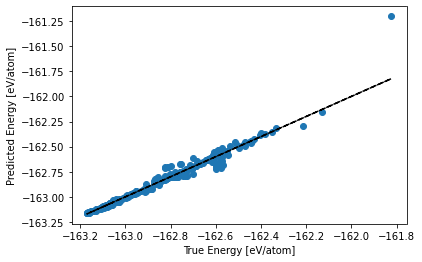

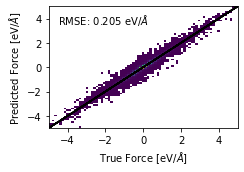

In [8]:
# evaluate its performances
val_features = features.get_subset(val_ind)
%time ep, fp = model_lin.predict_from_features(val_features)
print_score(ep/nat_val, e_val/nat_val)
print_score(fp.flatten(), f_val.flatten())
# print_score(vp.flatten(), s_val.flatten())

plt.scatter(e_val/nat_val, ep/nat_val)
plt.plot(e_val/nat_val, e_val/nat_val, 'k--')
plt.xlabel("True Energy [eV/atom]")
plt.ylabel("Predicted Energy [eV/atom]")
plt.show()

plt.figure(figsize = (3.5, 2.5))
plt.hist2d(np.ravel(f_val), np.ravel(fp), cmin = 1e-12, bins = 100, cmap = 'viridis')
plt.plot(f_val, f_val, 'k--')
plt.xlim(-5, 5)
plt.ylim(-5, 5)
plt.xlabel("True Force [eV/$\AA$]")
plt.ylabel("Predicted Force [eV/$\AA$]")
plt.text(-4.5, 3.5, 'RMSE: 0.205 eV/$\AA$')
plt.tight_layout()
plt.savefig("../../plots/Si_linear.png", dpi=400)

## train an ensemble of linear models

In [9]:
# features = load(input_file[:-4] + "_features.xz")

CPU times: user 1.21 s, sys: 314 ms, total: 1.53 s
Wall time: 1.14 s
MAE=0.010 RMSE=0.021 SUP=0.151 R2=0.990
MAE=0.071 RMSE=0.122 SUP=2.852 R2=0.973


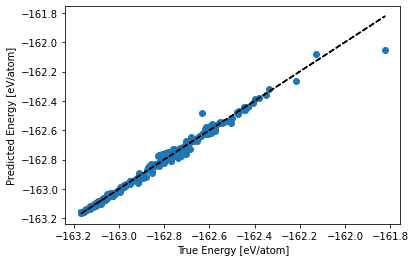

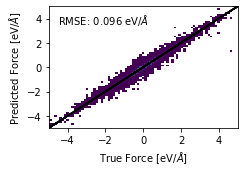

In [11]:
noise = 1e-8
n_clusters = 8
clustering_type = 'kmeans'
# get the subset of features for training
tr_features = features.get_subset(tr_ind)
# train the model
model_ens =  LPEnsamble(n_clusters=n_clusters, clustering_type=clustering_type, baseline_percentile=0)
model_ens.fit_from_features(tr_features, e_t, f_t, noise)

# evaluate its performances
val_features = features.get_subset(val_ind)
%time ep, fp = model_ens.predict_from_features(val_features)
# vp = model.predict_stress(val_features)

print_score(ep/nat_val, e_val/nat_val)
print_score(fp.flatten(), f_val.flatten())
# print_score(vp.flatten(), s_val.flatten())

plt.scatter(e_val/nat_val, ep/nat_val)
plt.plot(e_val/nat_val, e_val/nat_val, 'k--')
plt.xlabel("True Energy [eV/atom]")
plt.ylabel("Predicted Energy [eV/atom]")
plt.show()

plt.figure(figsize = (3.5, 2.5))
plt.hist2d(np.ravel(f_val), np.ravel(fp), cmin = 1e-12, bins = 100, cmap = 'viridis')
plt.plot(f_val, f_val, 'k--')
plt.xlim(-5, 5)
plt.ylim(-5, 5)
plt.xlabel("True Force [eV/$\AA$]")
plt.ylabel("Predicted Force [eV/$\AA$]")
plt.text(-4.5, 3.5, 'RMSE: 0.096 eV/$\AA$')
plt.tight_layout()
plt.savefig("../../plots/Si_ensemble.png", dpi=400)

400.33851265232084
17.0841464335089
13.07242350971147
58.10878065591502
369.77614646739994
49.96158683624834
10.347701370910956
11.628575297229276


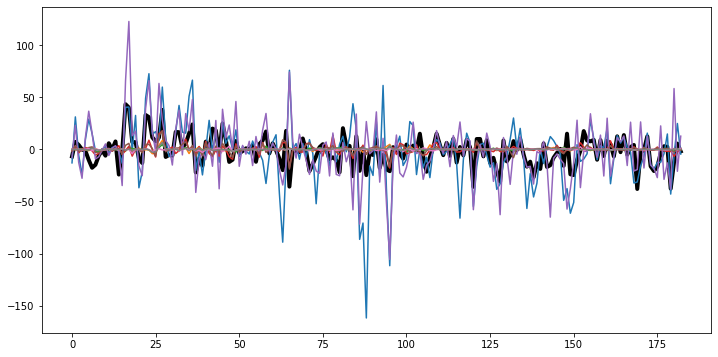

In [13]:
plt.figure(figsize = (12, 6))
plt.plot(model_lin.weights, 'k-', lw = 4)
for n in model_ens.potentials.keys():
    plt.plot(model_ens.potentials[n].weights)
    print(np.linalg.norm(model_ens.potentials[n].weights))
plt.show()

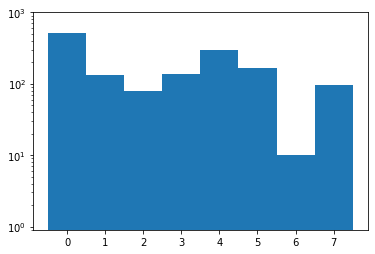

In [17]:
plt.hist(model_ens.clustering.labels, bins = np.linspace(-0.5, n_clusters - 0.5, n_clusters+1))
plt.yscale('log')
plt.ylim(9e-1, 1000)
plt.show()

In [15]:
# # save the model
# dump('./model.xz',model)

# use the model for cell optimization

In [19]:
from ase.lattice.cubic import FaceCenteredCubic, Diamond
from scipy.optimize import leastsq, minimize
from ase.build import bulk
from ase.optimize import LBFGS
from ase.optimize import FIRE
from ase.optimize import MDMin
from ase.md.langevin import Langevin
from ase import constraints
from ase.constraints import StrainFilter

In [22]:
calc = ASEMLCalculator(model_ens)

In [ ]:
latticeconstant = 4.5
atoms = bulk('Si', 'diamond', a=latticeconstant, cubic=True)
atoms.set_calculator(calc)
filt = StrainFilter(atoms)
opt = FIRE(filt)
opt.run(5e-4)
enRef = atoms.get_potential_energy()
volRef = atoms.get_volume()
atoms.get_cell(), enRef, volRef**(1/3)